# TP2
### Étudiant
    1. Félix Moreau 1846157
    2. Axel Massucci Templier
    3. Hermann Noubissie Noussa
    4. Pier-Olivier Côté


In [227]:
import yfinance as yf 
from pandas_datareader import data, wb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
import math as mt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
#from Data_TP2_V2 import BBANDS, STOK, MACD, RSI, MFI
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import talib
import pylab
from sklearn import preprocessing

In [228]:
start_sp = datetime.datetime(2018,3,31)
end_sp = datetime.datetime(2020, 12,31)

# Use Vanguard ETF
# SP500 Index + 11 Industry

BLack_ETF=['IVV','IWF','IJH','IJR','IWM','IVW']
'''
BLack_ETF=['IVV','IWF','IJH','IJR','IWM','IWD','ITOT','IVW','IWB','IWR','DVY',
           'IVE','IWP','IWS','IWV','IUSG','IWO','IWN','IBB','IJK','IUSV',
           'OEF','IJS','IJJ','IYW','IHI','IJT','ITA','IGV','IYH','SOXX','EWC',
           'IGM','IYF','JKE','SUSA','IDU','IYY','IYG','JKD','IYC','IYJ','JKG',
           'IWC','IYK','JKF','JKH','IYT','JKI','IYZ','IGE','IYE','JKL','IYM',
           'JKJ','JKK','IGN']
           

'''
# To access data for SP500
#SP500_dat=Data['IVW']

# To access the adjusted close price, use
#Data['IVW']['Adj Close']

# Graph data
#Data['IVW']['Adj Close'].plot(grid=True)

# To get Information about a ticker
#SP500_detail = yf.Ticker("IVW")

# Show stock info
#SP500_detail.info

"\nBLack_ETF=['IVV','IWF','IJH','IJR','IWM','IWD','ITOT','IVW','IWB','IWR','DVY',\n           'IVE','IWP','IWS','IWV','IUSG','IWO','IWN','IBB','IJK','IUSV',\n           'OEF','IJS','IJJ','IYW','IHI','IJT','ITA','IGV','IYH','SOXX','EWC',\n           'IGM','IYF','JKE','SUSA','IDU','IYY','IYG','JKD','IYC','IYJ','JKG',\n           'IWC','IYK','JKF','JKH','IYT','JKI','IYZ','IGE','IYE','JKL','IYM',\n           'JKJ','JKK','IGN']\n           \n\n"

In [229]:
def get_Data_bin(ticker):
    Data = yf.download(ticker, start=start_sp, end=end_sp,group_by="ticker")
    rendement = pd.DataFrame(Data['Adj Close'].T.pct_change())
    rendement_bin = pd.DataFrame(np.where(rendement['Adj Close'].shift(-1) > rendement['Adj Close'], 1, 0),
                                index = rendement.index)
    return rendement_bin, Data

In [230]:
def data_preprocessing(ticker, Data):
    dataset = pd.DataFrame(index = Data.index)
    dataset['H-L'] = Data['High'] - Data['Low']
    dataset['O-C'] = Data['Close'] - Data['Open']
    
    dataset['ma_5'] = Data['Close'].rolling(window=5).mean()
    dataset['ma_10'] = Data['Close'].rolling(window=10).mean()
    
    dataset['EWMA_12'] = Data['Close'].ewm(span=12).mean()

    dataset['std_5'] = Data['Close'].rolling(window=5).std()
    dataset['std_10'] = Data['Close'].rolling(window=10).std()
    
    dataset['Williams %R'] = talib.WILLR(Data['High'].values,
                                         Data['Low'].values, Data['Close'].values, 7)
    #RSI
    dataset['RSI'] = talib.RSI(Data['Close'], timeperiod = 14)
    #conditions  = [dataset['RSI'] >= 70, (dataset['RSI'] < 70) & (dataset['RSI']> 30), dataset['RSI'] <= 30 ]
    #choices     = [ -1, 0, 1 ]
    #dataset['RSI'] = np.select(conditions, choices, default=np.nan)

    #MFI
    dataset['MFI'] = talib.MFI(Data['High'], Data['Low'], Data['Close'], Data['Volume'], timeperiod=14)
    #conditions  = [dataset['MFI'] >= 70, (dataset['MFI'] < 70) & (dataset['MFI']> 30), dataset['MFI'] <= 30 ]
    #choices     = [ -1, 0, 1 ]
    #dataset['MFI'] = np.select(conditions, choices, default=np.nan)
    
    #BBANDS
    #dataset['BBANDS_UP'], centre, dataset['BBANDS_DOWN'] = talib.BBANDS(
    #    Data['Close'],timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
                                                                                       
    #STOCHASTIC  
    dataset['STO_k'], dataset['STO_d'] = talib.STOCH(Data['High'], Data['Low'], Data['Close'],
                         fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    #k = dataset['STO_k']
    #d = dataset['STO_d']
    #conditions  = [(k>=80)&(d>=80),(k<80)&(d<80)&(k>=20)&(d>=20),(k<20)&(d<20)]
    #dataset['STO'] = np.select(conditions, choices, default=np.nan)
    
    #MACD
    macd, dataset['MACD'], macdhist = talib.MACD(Data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    #conditions  = [dataset['MACD'] < 0,dataset['MACD']==0 , dataset['RSI'] > 0 ]
    #choices     = [ -1, 0, 1 ]
    #dataset['MACD'] = np.select(conditions, choices, default=np.nan)
    
    #ADX
    dataset['ADX'] = talib.ADX(Data['High'], Data['Low'], Data['Close'], timeperiod=14)
    
    #MA
    dataset['MA'] = talib.MA(Data['Close'], timeperiod=30, matype=0)
    
    #SMA
    dataset['SMA'] = talib.SMA(Data['Close'], timeperiod=30)
    
    #SAR
    dataset['SAR'] = talib.SAR(np.array(Data['High']), np.array(Data['Low']), 0.2, 0.2)
    
    return dataset

In [231]:
X=pd.DataFrame()
Y=pd.DataFrame()
for etf in BLack_ETF:
    Y_bin, Data = get_Data_bin(etf)
    dataset_ini = data_preprocessing(etf, Data)
    X = pd.concat([X,dataset_ini])
    Y = pd.concat([Y,Y_bin])
X['Y'] = Y
X = X.dropna()
Y = X['Y']
X1 = X.drop(columns = ['Y'])
X = pd.DataFrame(preprocessing.scale(X1), columns=X1.columns)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [232]:
df = pd.DataFrame([data.DataReader(etf, 'yahoo', start_sp, end_sp)['Adj Close'] for etf in BLack_ETF]).T
df.columns = BLack_ETF
rendement = df.pct_change()

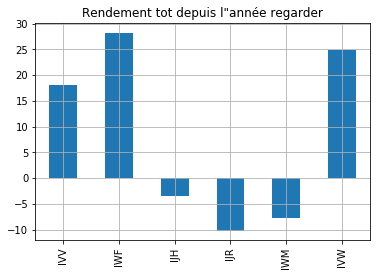

In [233]:
somme = rendement.sum()*100
somme.plot(kind='bar', grid=True, title = 'Rendement tot depuis l"année regarder')

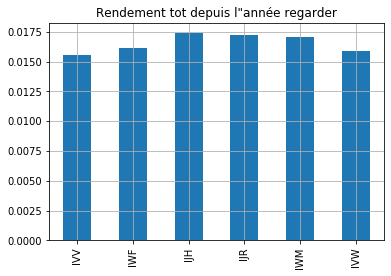

In [234]:
allo=rendement.std()
allo.plot(kind='bar', grid=True, title = 'Rendement tot depuis l"année regarder')

# 1) Modele Logit

In [235]:
def calculate_aic(n, mse, num_params):
    aic = n * mt.log(mse) + 2 * num_params
    return aic

In [236]:
def calculModelLogit(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 0)
    ModeleLogit = LogisticRegression()
    TrainFit = ModeleLogit.fit(trainX, trainY)
    TrainScores = ModeleLogit.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleLogit.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleLogit.predict(testX)
    proba = ModeleLogit.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, ModeleLogit.coef_, testY, ModeleLogit, proba, trainY, trainX

In [237]:
def getROC(yTest, prediction, proba):
    fpr, tpr, thres = roc_curve(yTest, proba)
    ac = roc_auc_score(yTest, prediction)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % ac)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [238]:
def getMC(yTest, prediction):
    matrice = confusion_matrix(yTest, prediction)
    print(matrice) 

In [239]:
def verificationCoef(coef, data):
    dataAmeliorer = data
    for i in range(0,len(coef)):
        if coef[i] < -0.5:
            sigle = data.columns[i]
#print(sigle)
            if sigle in dataAmeliorer.columns:
                dataAmeliorer = dataAmeliorer.drop(sigle, axis="columns")
    return dataAmeliorer

In [240]:
predictions, TrainScores, TestsScorelogit, aic, coefficientModel, testY, model, proba, trainY, trainX = calculModelLogit(X, Y)

Train score= 0.7169905331340309
Test score= 0.6957026713124274
AIC score : -990.3747505739718


Pour l'echantillon d'entrainement

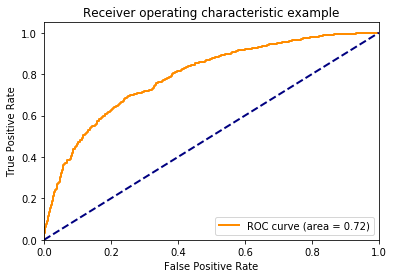

In [241]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [242]:
getMC(trainY, model.predict(trainX))

[[800 237]
 [331 639]]


Pour l'echantillon test

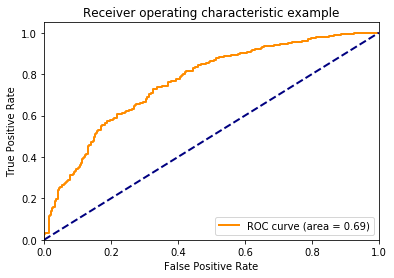

In [243]:
getROC(testY, predictions, proba)

In [244]:
getMC(testY, predictions)

[[347 100]
 [162 252]]


In [245]:
variableImportante2 = pd.DataFrame(coefficientModel, columns=X1.columns).T
var2 = variableImportante2.sort_values(by=0,ascending = False)
var2

,0
STO_k,0.760477
STO_d,0.272208
ma_10,0.224655
H-L,0.134855
EWMA_12,0.096373
ma_5,0.082571
MFI,0.055757
SMA,-0.011519
MA,-0.011519
MACD,-0.046785


## Changer les paramètres afin d'avoir une meilleure classification

In [246]:
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
feature_list = list(X1.columns)
rfe = RFE(model,8)
rfe = rfe.fit(X, Y)
print(rfe.support_)
print(rfe.ranking_)
rapport = rfe.support_

nouvelleBD = X
## On veut visualiser les variables qui ne sont pas sélectionnées
for i in range(0,len(rapport)):
    if rapport[i]==False :
        sigle = X
        print("Le paramètre:",feature_list[i], "n'est pas selectionné")
        nouvelleBD = nouvelleBD.drop(columns = feature_list[i])

[False  True False  True False False False  True False False  True  True
 False False  True  True  True]
[ 5  1  4  1  3  2  9  1  8 10  1  1  6  7  1  1  1]
Le paramètre: H-L n'est pas selectionné
Le paramètre: ma_5 n'est pas selectionné
Le paramètre: EWMA_12 n'est pas selectionné
Le paramètre: std_5 n'est pas selectionné
Le paramètre: std_10 n'est pas selectionné
Le paramètre: RSI n'est pas selectionné
Le paramètre: MFI n'est pas selectionné
Le paramètre: MACD n'est pas selectionné
Le paramètre: ADX n'est pas selectionné


In [247]:
predictions, TrainScores, TestsScorelogit, aic, coefficientModel, testY, model, proba, trainY, trainX = calculModelLogit(nouvelleBD, Y)

Train score= 0.7219730941704036
Test score= 0.6910569105691057
AIC score : -995.3290464512332


Pour l'echantillon d'entrainement 

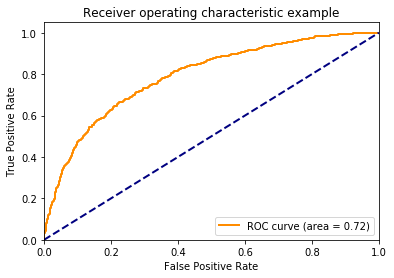

In [248]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [249]:
getMC(trainY, model.predict(trainX))

[[805 232]
 [326 644]]


Pour l'echantillon test

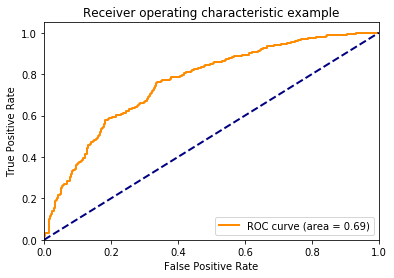

In [250]:
getROC(testY, predictions, proba)

In [251]:
getMC(testY, predictions)

[[344 103]
 [163 251]]


In [252]:
coefficientModel

array([[-0.64645039,  0.41275665, -1.48735174,  0.72973034,  0.28012294,
        -0.1534723 , -0.1534723 , -0.07700281]])

#### Le AIC, en utilisant la méthode récursive à diminuer, par contre, l'accuracy a augmenter de0,2%. Le % du test est de 68,8% ce qui est bien pour un modèle et le nombr de bon résultats est égale à 344 +252= 596.

# 2) Arbre de decision

In [253]:
def calculModelArbreDecision(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 0)
    ModeleArbre = DecisionTreeClassifier()
    
    TrainFit = ModeleArbre.fit(trainX, trainY)
    
    TrainScores = ModeleArbre.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleArbre.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleArbre.predict(testX)
    
    proba = ModeleArbre.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, testY, testX, proba, trainY, trainX, ModeleArbre

In [254]:
predictions, TrainScores, TestsScoretree, aic, testY, testX, prob, trainY, trainX, model = calculModelArbreDecision(X, Y)

Train score= 1.0
Test score= 0.662020905923345
AIC score : -899.9880352776212


Pour l'echantillon d'entrainement

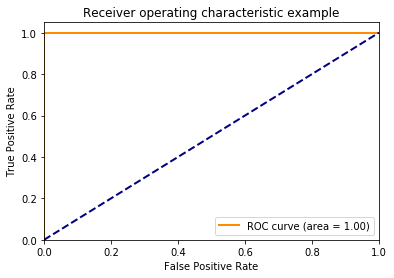

In [255]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [256]:
getMC(trainY, model.predict(trainX))

[[1037    0]
 [   0  970]]


Pour l'echantillon test

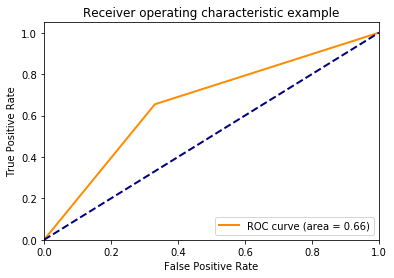

In [257]:
getROC(testY, predictions, prob)

In [258]:
getMC(testY, predictions)

[[299 148]
 [143 271]]


Avec les variables sélectionnées par le modèle Logit

In [259]:
nouvellePredictions, nouveauTrainScores, nouveauTestsScore, nouveauAIC, nouveautestY, nouveautestX, prob, nouveauTrainY, nouveautrainX, nouveauModel = calculModelArbreDecision(nouvelleBD, Y)

Train score= 1.0
Test score= 0.629500580720093
AIC score : -838.889828814525


Pour l'echantillon d'entrainement

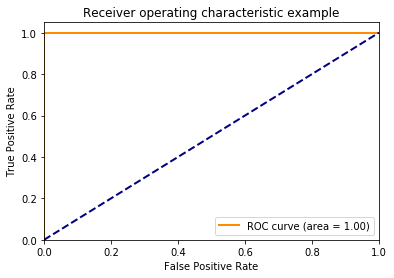

In [260]:
getROC(nouveauTrainY, nouveauModel.predict(nouveautrainX), nouveauModel.predict_proba(nouveautrainX)[:,1])

In [261]:
getMC(nouveauTrainY, nouveauModel.predict(nouveautrainX))

[[1037    0]
 [   0  970]]


Pour l'echantillon test

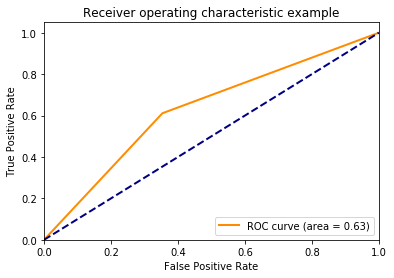

In [262]:
getROC(nouveautestY, nouvellePredictions, prob)

In [263]:
getMC(nouveautestY, nouvellePredictions)

[[289 158]
 [161 253]]


### Diminution de la précision de 2% lorsqu'on utilise les paramètres sélectionnés par l'arbre de décision

# Random Forest

In [264]:
def calculModelRandomForest(X,Y):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 42)
    ModeleRF = RandomForestClassifier()
    
    TrainFit = ModeleRF.fit(trainX, trainY)
    
    TrainScores = ModeleRF.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleRF.score(testX, testY)
    print('Test score=',TestsScore)
    
    predictions = ModeleRF.predict(testX)
    
    proba = ModeleRF.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    variableImportante = ModeleRF.feature_importances_
    return predictions, TrainScores, TestsScore, aic, testY, variableImportante, proba, trainY, trainX, ModeleRF

In [265]:
predictions, TrainScores, TestsScoreforest, AIC, testY, variableImportante, prob, trainY, trainX, model = calculModelRandomForest(X, Y)

Train score= 0.9785749875435974
Test score= 0.6794425087108014
AIC score : -945.5542229298102


Pour l'echantillon d'entrainement 

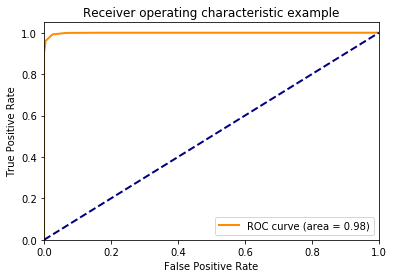

In [266]:
getROC(trainY, model.predict(trainX), model.predict_proba(trainX)[:,1])

In [267]:
getMC(trainY, model.predict(trainX))

[[1031    5]
 [  38  933]]


Pour l'echantillon test

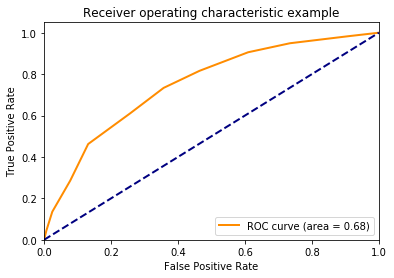

In [268]:
getROC(testY, predictions, prob)

In [269]:
getMC(testY, predictions)

[[333 115]
 [161 252]]


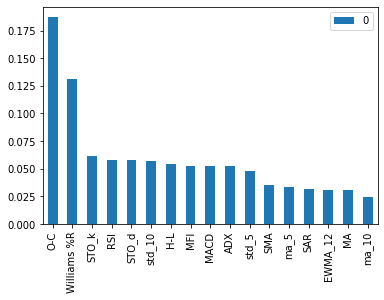

In [270]:
variableImportante1 = pd.DataFrame(variableImportante, index=X.columns)
variableImportante1.sort_values(by=0,ascending = False).plot(kind='bar')

#### Les variables importantes du Random Forest sont :
#### - O-C
#### - Williams %R
#### - Stochastique_k
#### - RSI
#### - Stochastique_d
#### Les variables importantes du Logit sont :
#### - ma_10	
#### - MACD	
#### - ma_5	
#### - EWMA_12	
#### - H-L	
##### La différence est que le modèle logit utilise des valeurs que ne varie pas beaucoup et qui sont assez stable comparativement à random forest qui choisi des variables qui bougent beaucoup

# Répétez l’exercices pour des méthodes plus flexibles mais opaques.

In [271]:
from sklearn.svm import SVC 
def calculModelSVM(X,Y,typ):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.30, random_state = 42)
    ModeleSVM = SVC(kernel=typ)
    
    TrainFit = ModeleSVM.fit(trainX, trainY)
    
    TrainScores = ModeleSVM.score(trainX, trainY)
    print('Train score=',TrainScores)
    
    TestsScore = ModeleSVM.score(testX, testY)
    print('Test score=',TestsScore)
    
    #proba = ModeleSVM.predict_proba(testX)[:,1]
    
    mse = mean_squared_error(testY, predictions)
    aic = calculate_aic(len(testY),mse,len(X.T))
    print('AIC score :',aic)
    return predictions, TrainScores, TestsScore, aic, testY, proba, trainY, trainX, ModeleSVM

In [272]:
predictions, TrainScores, TestsScorelin, aic, testY, prob, trainY, trainX, ModeleSVM = calculModelSVM(X,Y,'linear')

Train score= 0.7070254110612855
Test score= 0.70267131242741
AIC score : -945.5542229298102


Pour l'echantillon test

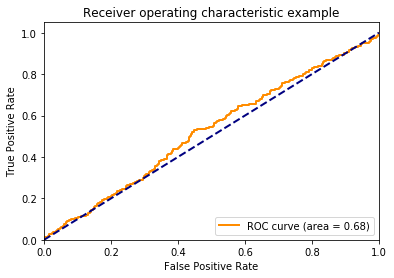

In [273]:
getROC(testY, predictions, prob)

In [274]:
getMC(testY, predictions)

[[333 115]
 [161 252]]


In [275]:
predictions, TrainScores, TestsScoreradial, aic, testY, prob, trainY, trainX, model = calculModelSVM(X,Y,'rbf')

Train score= 0.7433981066268062
Test score= 0.6945412311265969
AIC score : -945.5542229298102


Pour l'echantillon test

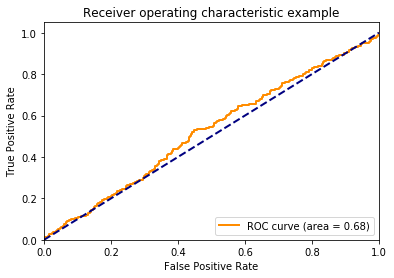

In [276]:
getROC(testY, predictions, prob)

In [277]:
getMC(testY, predictions)

[[333 115]
 [161 252]]


# Comparer une dernière fois, l’ensemble des modèles, sélectionnez-en un et expliquez votre choix.

In [278]:
accuracy = pd.DataFrame([TestsScorelogit,TestsScoreforest,TestsScoretree, TestsScoreradial,TestsScorelin],
                       index = ['Logit','Forest','Tree','Radial','Linéaire'], columns = ['%Tests'])*100
accuracy

,%Tests
Logit,69.105691
Forest,67.944251
Tree,66.202091
Radial,69.454123
Linéaire,70.267131


#### Le modèle le plus précis est celui du random forest avec 72 %. Il fait tout les possibilités possibles ce qui rend son modele précis dans ce cas.

# Répétez l’exercice mais cette fois-ci pour chaque ETF pris individuellement.

In [279]:
modele_unique = pd.DataFrame(index = BLack_ETF)
testscore=[]
AIC = []
for etf in BLack_ETF:
    Y,Data = get_Data_bin(etf)
    X = data_preprocessing(etf,Data)
    X['Y']=Y
    X = X.dropna()
    Y = X['Y']
    X = X.drop(columns = ['Y'])
    print(X.shape)
    print(Y.shape)
    predictions, TrainScores, TestsScoreforest, aic, testY, variableImportante, prob, trainY, trainX, model = calculModelRandomForest(X, Y)
    testscore.append(TestsScoreforest)
    AIC.append(aic)
modele_unique['test']=testscore
modele_unique['AIC']=AIC
modele_unique

[*********************100%***********************]  1 of 1 completed
(478, 17)
(478,)
Train score= 0.9730538922155688
Test score= 0.6111111111111112
AIC score : -102.0024716730826
[*********************100%***********************]  1 of 1 completed
(478, 17)
(478,)
Train score= 0.9910179640718563
Test score= 0.6319444444444444
AIC score : -109.93107958743855
[*********************100%***********************]  1 of 1 completed
(478, 17)
(478,)
Train score= 0.9730538922155688
Test score= 0.6388888888888888
AIC score : -112.67401966321853
[*********************100%***********************]  1 of 1 completed
(478, 17)
(478,)
Train score= 0.9820359281437125
Test score= 0.6041666666666666
AIC score : -99.45373257076889
[*********************100%***********************]  1 of 1 completed
(478, 17)
(478,)
Train score= 0.9790419161676647
Test score= 0.6111111111111112
AIC score : -102.0024716730826
[*********************100%***********************]  1 of 1 completed
(478, 17)
(478,)
Train score=

,test,AIC
IVV,0.611111,-102.002472
IWF,0.631944,-109.931080
IJH,0.638889,-112.674020
IJR,0.604167,-99.453733
IWM,0.611111,-102.002472
IVW,0.597222,-96.949322


Source :

https://github.com/mrjbq7/ta-lib

https://medium.com/@rbhatia46/using-svm-on-top-of-technical-indicators-to-predict-reliance-stock-prices-abb494d9f45f